# Install Category Encoder and download

**Download Data**

In [ ]:
!wget https://raw.githubusercontent.com/coll-j/Tugas-KK/master/Minggu-3/data.csv

--2020-12-21 12:58:44--  https://raw.githubusercontent.com/coll-j/Tugas-KK/master/Minggu-3/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.05s   

2020-12-21 12:58:44 (25.7 MB/s) - ‘data.csv’ saved [1475504/1475504]



# Imports

In [ ]:
# Utils
import pandas as pd # Dataframe
import numpy as np
import math

# Model related
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.preprocessing import MinMaxScaler # Normalisasi
from sklearn.metrics import accuracy_score # Perhitungan akurasi

from keras.layers.convolutional import Conv1D, MaxPooling1D # Layer CNN
from keras.optimizers import Adam # Optimizer
from keras.models import Sequential # Model
from keras.layers import Dense, Dropout # Layer
from keras.callbacks import EarlyStopping

# Visualisasi
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

**Read data dan assign ke df. Drop kolom `Model` karena tidak akan dipakai**

In [ ]:
df = pd.read_csv('data.csv')
df.drop(columns=['Model', 'Market Category'], inplace=True)
df.head()

,Make,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,18,3916,34500


**Men-diskritkan fitur kontinu menggunakan qcut dari pandas dengan parameter `pd.qcut(kolom, jumlah_kelas, label)` dan replace kolom target (MSRP) dengan angka. Kolom yang didiskritkan menjadi 3 kelas antara lain:**

- **Engine HP**
- **highway MPG**
- **city mpg**
- **Popularity**

**Kolom MSRP didiskritkan menjadi 2 kelas murah dan mahal lalu diencode dengan cheap = 0 dan expensive = 1**

In [ ]:
numeric = []
for col in df.drop(columns=['Number of Doors']).columns:
  print(df[col].dtypes)
  if df[col].dtypes != 'object': # Yang diambil hanya kolom numerik
    numeric.append(col)
numeric

object
int64
object
float64
float64
object
object
object
object
int64
int64
int64
int64


['Year',
 'Engine HP',
 'Engine Cylinders',
 'highway MPG',
 'city mpg',
 'Popularity',
 'MSRP']

In [ ]:
df_disc = df[numeric]

df_disc['MSRP'] = pd.qcut(df_disc['MSRP'], 2, labels=['cheap', 'expensive']) # Membagi MSRP antara murah atau mahal, binary
df_disc['MSRP'].replace({'cheap': 0, 'expensive': 1}, inplace=True) # mengubah label jadi angka
df_disc.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Year,Engine HP,Engine Cylinders,highway MPG,city mpg,Popularity,MSRP
0,2011,335.0,6.0,26,19,3916,1
1,2011,300.0,6.0,28,19,3916,1
2,2011,300.0,6.0,28,20,3916,1
3,2011,230.0,6.0,28,18,3916,0
4,2011,230.0,6.0,28,18,3916,1


**Impute tidak dilakukan, maka semua record yang memiliki null values di-drop. Setelah drop menyisakan `11812` data**

In [ ]:
df_disc.dropna(inplace=True) # Drop missing values
df_disc.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,Engine HP,Engine Cylinders,highway MPG,city mpg,Popularity,MSRP
count,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000
mean,2010.360190,249.514472,5.650051,26.319736,19.326845,1553.510833,0.496869
std,7.594077,109.261297,1.752333,7.442964,6.527183,1439.969241,0.500011
min,1990.000000,55.000000,0.000000,12.000000,7.000000,2.000000,0.000000
25%,2007.000000,170.000000,4.000000,22.000000,16.000000,549.000000,0.000000
50%,2015.000000,227.000000,6.000000,26.000000,18.000000,1385.000000,0.000000
75%,2016.000000,300.000000,6.000000,30.000000,22.000000,2009.000000,1.000000
max,2017.000000,1001.000000,16.000000,354.000000,137.000000,5657.000000,1.000000


In [ ]:
X, y = df_disc.drop(columns=['MSRP']), df_disc['MSRP'] # Membagi data antara input (X) dan output (y)
X

,Year,Engine HP,Engine Cylinders,highway MPG,city mpg,Popularity
0,2011,335.0,6.0,26,19,3916
1,2011,300.0,6.0,28,19,3916
2,2011,300.0,6.0,28,20,3916
3,2011,230.0,6.0,28,18,3916
4,2011,230.0,6.0,28,18,3916
...,...,...,...,...,...,...
11909,2012,300.0,6.0,23,16,204
11910,2012,300.0,6.0,23,16,204
11911,2012,300.0,6.0,23,16,204
11912,2013,300.0,6.0,23,16,204


# Normalisasi

In [ ]:
# Normalisasi
scaler = MinMaxScaler() # Range 0-1
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.77777778, 0.29598309, 0.375     , 0.04093567, 0.09230769,
        0.69213086],
       [0.77777778, 0.2589852 , 0.375     , 0.04678363, 0.09230769,
        0.69213086],
       [0.77777778, 0.2589852 , 0.375     , 0.04678363, 0.1       ,
        0.69213086],
       ...,
       [0.81481481, 0.2589852 , 0.375     , 0.03216374, 0.06923077,
        0.0357206 ],
       [0.85185185, 0.2589852 , 0.375     , 0.03216374, 0.06923077,
        0.0357206 ],
       [0.59259259, 0.17547569, 0.375     , 0.04093567, 0.07692308,
        0.01043324]])

# Training

**Dalam proses training dicoba dengan beberapa ukuran training yang ditentukan oleh ukuran data testing.**

> jumlah data training = jumlah keseluruhan data - jumlah data testing

**Jumlah data testing direpresentasikan dalam presentase sehingga jika di-tablekan menjadi:**

> testing | training
> --- | ---
> 0.6 | 0.4
> 0.5 | 0.5
> 0.4 | 0.6
> 0.3 | 0.7

**Alur percobaan dilakukan dengan looping setiap parameter model:**
1. Inisiasi model
2. Fitting model terhadap data training
3. Prediksi model terhadap data testing
4. Perhitungan akurasi dan f1 terhadap data testing
5. Pemilihan parameter terbaik sesuai akurasi dari data testing

In [ ]:
# Splitting data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

8271 8271 3545 3545


In [ ]:
# Mengubah dimensi input agar menjadi 3 dimensi
# Karena Conv1D menerima input dalam dimensi minimal 3
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train_reshaped.shape[1:3]

(6, 1)

In [ ]:
# Sama dengan atas, untuk data testing
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test_reshaped.shape

(3545, 6, 1)

In [ ]:
model = Sequential()
# Hidden layer 1
model.add(Conv1D(32, 4, input_shape=X_train_reshaped.shape[1:3], activation='relu'))
model.add(Dropout(0.5))

# Hidden Layer 2
model.add(Conv1D(16, 2))
model.add(Dropout(0.3))

# Hidden Layer 3
# model.add(Conv1D(32, 2))
# model.add(Dropout(0.3))

# Output layer
model.add(MaxPooling1D(2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3, 32)             160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 16)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
____________________________________________________

In [ ]:
lr = 0.001
optimizer = Adam(learning_rate=lr)

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='accuracy', # Stopping berdasarkan akurasi
    min_delta=0,
    patience=100, # Stopping setelah 100 iterasi tidak ada peningkatan akurasi
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
%%timeit -n 1
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
history = model.fit(X_train_reshaped, y_train, # Data training
          epochs=1000, 
          batch_size=32, 
          verbose=1, # Print progres
          validation_data=(X_test_reshaped, y_test), # Data Validasi
          callbacks=[early_stopping_monitor])

Epoch 1/1000
259/259 [==============================] - 1s 3ms/step - loss: 0.6463 - accuracy: 0.6210 - val_loss: 0.4129 - val_accuracy: 0.8409
Epoch 2/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.4141 - accuracy: 0.8238 - val_loss: 0.3382 - val_accuracy: 0.8415
Epoch 3/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.3633 - accuracy: 0.8444 - val_loss: 0.3229 - val_accuracy: 0.8446
Epoch 4/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.3654 - accuracy: 0.8456 - val_loss: 0.3124 - val_accuracy: 0.8660
Epoch 5/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.3462 - accuracy: 0.8519 - val_loss: 0.3021 - val_accuracy: 0.8621
Epoch 6/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.3382 - accuracy: 0.8603 - val_loss: 0.2961 - val_accuracy: 0.8722
Epoch 7/1000
259/259 [==============================] - 1s 2ms/step - loss: 0.3342 - accuracy: 0.8631 - val_loss: 0.2939 - val_accuracy:

# Evaluation

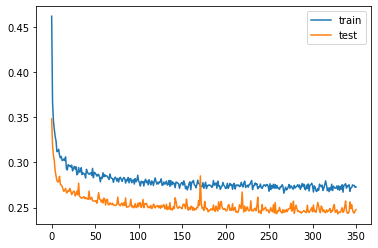

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
preds = model.predict(X_test_reshaped) # ex: [[0.99], [0.00004], [0.76],...]
preds = np.round(preds, 0).reshape(preds.shape[0]) # Pembulatan prediksi dan perubahan dimensi ex: [1, 0, 1, ...]
acc = accuracy_score(y_test, preds)
# preds.shape
acc

0.8902679830747532